**INTRODUCTION**

The goal of this notebook is to predict arrhytmia on ECG. It is based on the MIT-BIH dataset.

In particular, this notebook aims at having a first assessment of the impact of adding an LSTM with an attention mechanism compared to the single CNN implemented in https://www.kaggle.com/code/gregoiredc/arrhythmia-on-ecg-classification-using-cnn.

The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.
souces : https://physionet.org/content/mitdb/1.0.0/


Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]


-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats

**Load Data**

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


In [25]:
train_df=pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv',header=None)

In [26]:
train_df_plot=train_df.copy()
train_df_plot.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Atrial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
train_df_plot['label'] = train_df_plot.iloc[:, -1].map(id_to_label)
print(train_df_plot.info())
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 126.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None


**Balance of dataset**

In [27]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)



0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


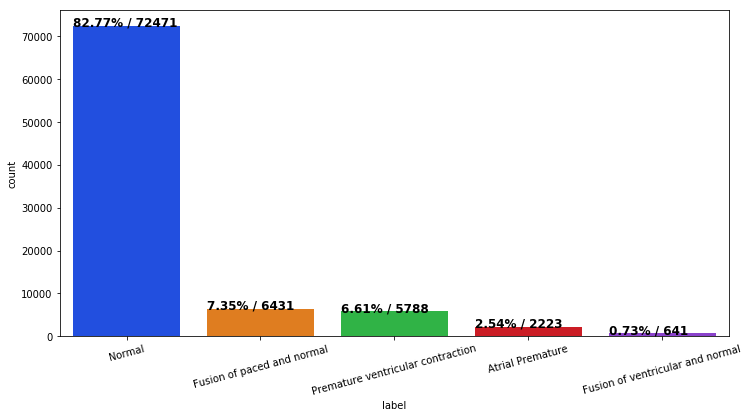

In [28]:
percentages = [count / train_df_plot.shape[0] * 100 for count in train_df_plot['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=train_df_plot['label'],
    ax=ax,
    palette="bright",
    order=train_df_plot['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    train_df_plot['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

We notice that there is a huge class imbalance. To overcome this issue, a resample technique is used.

In [29]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [30]:
equilibre=train_df[187].value_counts()
print(equilibre)


4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 10153 to 86696
Columns: 189 entries, 0 to label
dtypes: float64(187), int64(1), object(1)
memory usage: 145.0+ MB
None


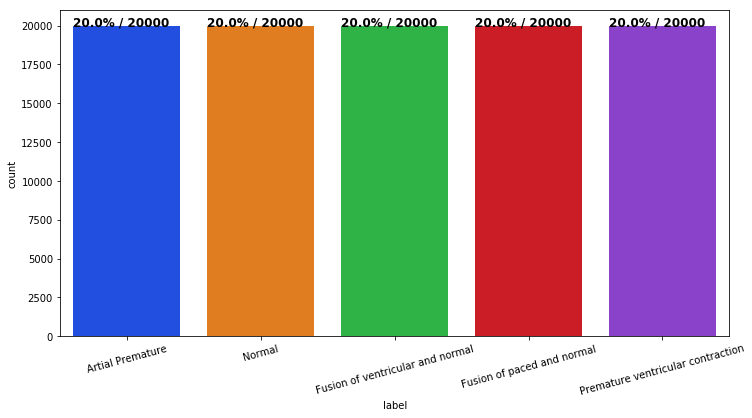

In [31]:
train_df_plot=train_df.copy()
train_df_plot.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
train_df_plot['label'] = train_df_plot.iloc[:, -1].map(id_to_label)
print(train_df_plot.info())

percentages = [count / train_df_plot.shape[0] * 100 for count in train_df_plot['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=train_df_plot['label'],
    ax=ax,
    palette="bright",
    order=train_df_plot['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    train_df_plot['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

**Classes**

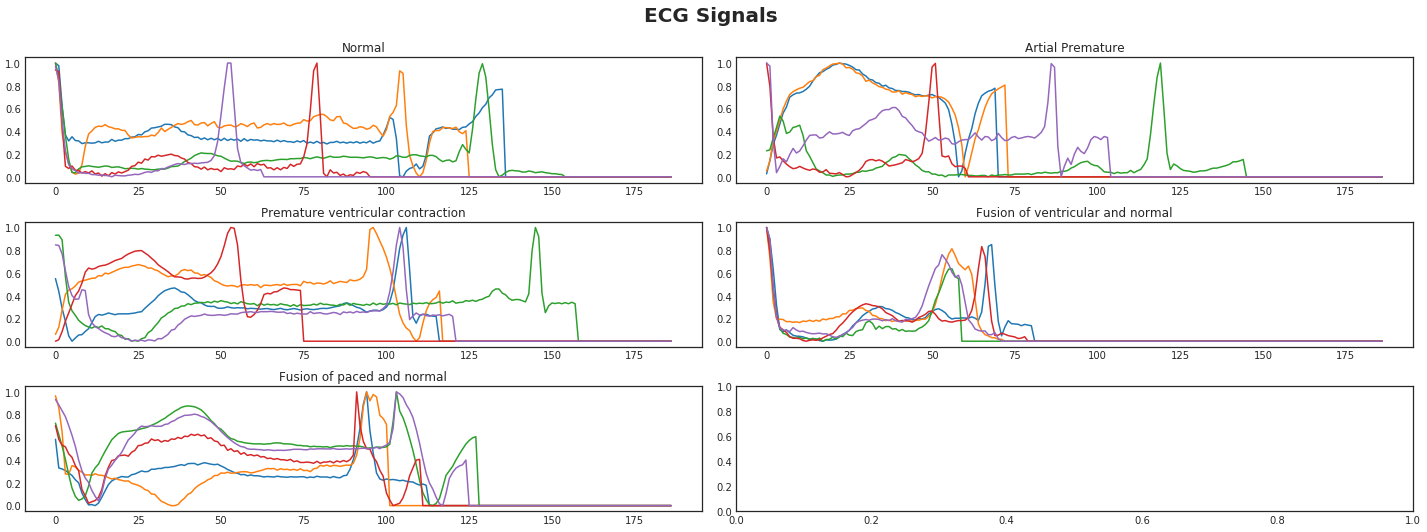

In [32]:
N = 5
samples = [train_df_plot.loc[train_df_plot['class'] == cls].sample(N) for cls in range(N)]
titles = [id_to_label[cls] for cls in range(5)]

with plt.style.context("seaborn-white"):
    fig, axs = plt.subplots(3, 2, figsize=(20, 7))
    for i in range(5):
        ax = axs.flat[i]
        ax.plot(samples[i].values[:,:-2].transpose())
        ax.set_title(titles[i])
        #plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.suptitle("ECG Signals", fontsize=20, y=1.05, weight="bold")
    plt.savefig(f"signals_per_class.svg",
                    format="svg",bbox_inches='tight', pad_inches=0.2)
        
    plt.savefig(f"signals_per_class.png", 
                    format="png",bbox_inches='tight', pad_inches=0.2) 

**Pretreat**

To have datas leading to a better generalization, a gaussian noise is added to the training dataset.

In [33]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)


In [34]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [35]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

**Network**

The used network is a simple CNN with a bidirectional LSTM and an attention mechanism. The aim is to have a first, relatively simple architecture in order to have an early assessment of the impact of adding an LSTM with an attention mechanism compared to the single CNN implemented in https://www.kaggle.com/code/gregoiredc/arrhythmia-on-ecg-classification-using-cnn.

The idea of using LSTM + attention for such issues come from articles like :
   - Jiang M, Gu J, Li Y, Wei B, Zhang J, Wang Z, Xia L. HADLN: Hybrid Attention-Based Deep Learning Network for Automated Arrhythmia Classification. Front Physiol. 2021 Jul 5;12:683025. doi: 10.3389/fphys.2021.683025. PMID: 34290619; PMCID: PMC8289344.
   - Ghool, S. and Rocke, S., 2023, June. Exploring the Effectiveness of LSTM and Self-Attention Models for Artifact Detection in PPG Signals. In 2023 5th International Conference on Bio-engineering for Smart Technologies (BioSMART) (pp. 1-4). IEEE.
   - He, T., Chen, Y., Chen, J., Wang, W. and Zhou, Y., 2022. SEVGGNet-LSTM: a fused deep learning model for ECG classification. arXiv preprint arXiv:2210.17111.


In [58]:
def network(X_train,y_train,X_test,y_test):
    
    # CNN Layers
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    
    # LSTM Layer
    lstm = Bidirectional(LSTM(32, return_sequences=True))(inputs_cnn)
    
    # Attention Mechanism
    attention = Dense(1, activation='tanh')(lstm)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(64)(attention)
    attention = Permute([2, 1])(attention)
    
    # Merge CNN and LSTM layers using attention mechanism
    merged = M=multiply([lstm, attention])
    merged = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(64,))(merged)
    
    # Dense Layers
    dense_end1 = Dense(64, activation='relu')(merged)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    
    # Output Layer
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    # Compile Model
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    # Train Model
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    
    # Load Best Weights
    model.load_weights('best_model.h5')
    
    return(model,history)


In [59]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [61]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Bidirectional, LSTM
from keras.layers import Input, Lambda, Activation, RepeatVector, Permute, multiply, Reshape
from keras.models import Model
from keras import backend as K
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)



Train on 100000 samples, validate on 21892 samples
Epoch 1/40
100000/100000 [==============================] - 435s 4ms/step - loss: 1.3132 - accuracy: 0.4375 - val_loss: 1.5074 - val_accuracy: 0.1068
Epoch 2/40
100000/100000 [==============================] - 424s 4ms/step - loss: 1.3137 - accuracy: 0.4438 - val_loss: 1.3724 - val_accuracy: 0.1897
Epoch 3/40
100000/100000 [==============================] - 407s 4ms/step - loss: 1.1321 - accuracy: 0.5390 - val_loss: 1.3409 - val_accuracy: 0.3024
Epoch 4/40
100000/100000 [==============================] - 404s 4ms/step - loss: 0.9973 - accuracy: 0.6026 - val_loss: 1.0011 - val_accuracy: 0.5704
Epoch 5/40
100000/100000 [==============================] - 415s 4ms/step - loss: 0.9361 - accuracy: 0.6335 - val_loss: 0.8421 - val_accuracy: 0.6709
Epoch 6/40
100000/100000 [==============================] - 417s 4ms/step - loss: 0.8948 - accuracy: 0.6517 - val_loss: 1.0874 - val_accuracy: 0.5435
Epoch 7/40
100000/100000 [=======================

Accuracy: 67.09%


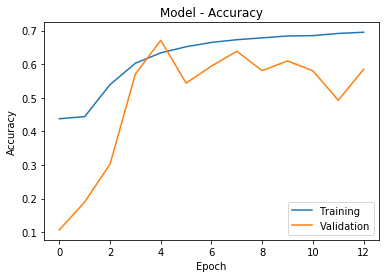

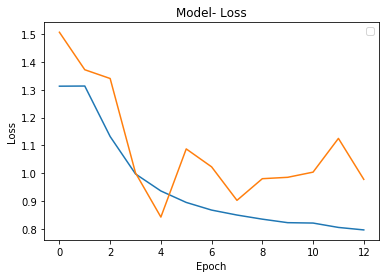

In [62]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)


On trouve une précision plus faible que celle du cas avec juste le CNN (72.45%).The accuracy is lower than that of the case with just the CNN (72.45%).

Normalized confusion matrix


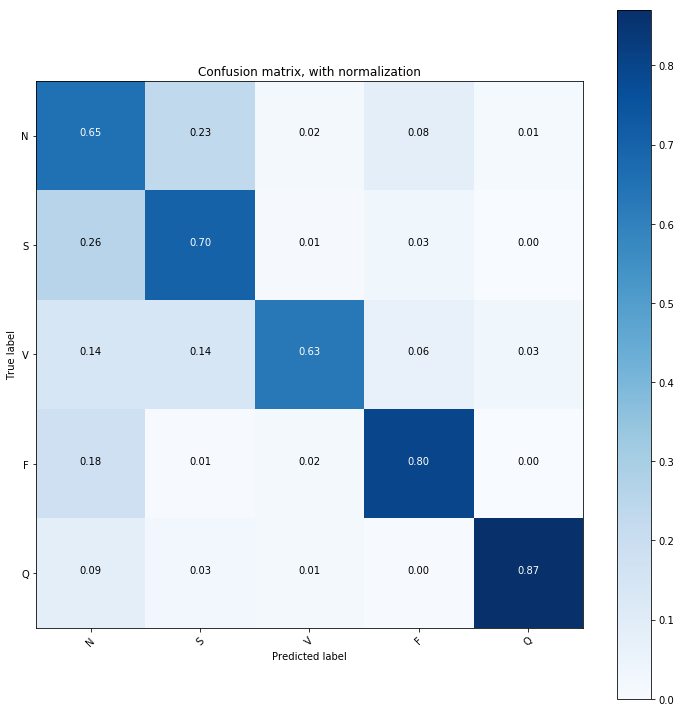

In [63]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()



Compared with the case using only the CNN, we found lower values for the best identified pathologies (N, F, Q) but higher values for the least well identified pathologies (S, V).
These first findings seem to suggest that the use of the LSTM and the attention mechanism is likely to be effective for pathologies that are difficult to detect.